<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/JB_Deep_learning_for_time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predict the Future with MLPs,
CNNs and LSTMs in Python

In [ ]:
# evaluate the finalized model on the validation dataset
import warnings
import itertools
import pandas as pd
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from pandas import Grouper
from pandas import Series
import numpy as np
from numpy import array
from matplotlib import pyplot
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AR

from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from math import sqrt
from math import exp
from math import log

# Chap 6 Prepare time series data for CNN and LSTM

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

In [ ]:
# define univariate time series
series = array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
print(series.shape)
# transform to a supervised learning problem
X, y = split_sequence(series, 3)
print(X.shape, y.shape)
# show each sample
for i in range(len(X)):
  print(X[i], y[i])

(10,)
(7, 3) (7,)
[1 2 3] 4
[2 3 4] 5
[3 4 5] 6
[4 5 6] 7
[5 6 7] 8
[6 7 8] 9
[7 8 9] 10


3D Data Preparation Basics

This expected three-dimensional structure of input data is often summarized using the array
shape notation of: [samples, timesteps, features]. Remember, that the two-dimensional
shape of a dataset that we are familiar with from the previous section has the array shape of:
[samples, features]. this means we are adding the new dimension of time steps. Except, in
time series forecasting problems our features are observations at time steps. So, really, we are
adding the dimension of features, where a univariate time series has only one feature

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

In [ ]:
# define univariate time series
series = array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
print(series.shape)
# transform to a supervised learning problem
X, y = split_sequence(series, 3)
print(X.shape, y.shape)
print('X',X)
print('y',y)
# transform input from [samples, features] to [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))
print('X.shape',X.shape)
print('X',X)

#three-dimensional suitable for fitting an LSTM or CNN and now has the shape [7, 3, 1] or 7
#samples, 3 time steps, 1 feature.

(10,)
(7, 3) (7,)
X [[1 2 3]
 [2 3 4]
 [3 4 5]
 [4 5 6]
 [5 6 7]
 [6 7 8]
 [7 8 9]]
y [ 4  5  6  7  8  9 10]
X.shape (7, 3, 1)
X [[[1]
  [2]
  [3]]

 [[2]
  [3]
  [4]]

 [[3]
  [4]
  [5]]

 [[4]
  [5]
  [6]]

 [[5]
  [6]
  [7]]

 [[6]
  [7]
  [8]]

 [[7]
  [8]
  [9]]]


Data Preparation Example

In [ ]:
# define the dataset
data = list()
n = 5000
for i in range(n):
  data.append([i+1, (i+1)*10])
data = array(data)
# drop time
data = data[:, 1]
print(data.shape)

(5000,)


In [ ]:
data

array([   10,    20,    30, ..., 49980, 49990, 50000])

In [ ]:
# split into samples (e.g. 5000/200 = 25)
samples = list()
length = 200
# step over the 5,000 in jumps of 200
for i in range(0,n,length):
  # grab from i to i + 200
  sample = data[i:i+length]
  samples.append(sample)
print(len(samples))
# chia 5000 dữ liệu thành 25 array, mỗi array 200 dữ liệu

25


In [ ]:
sample.shape

(200,)

In [ ]:
samples

[array([  10,   20,   30,   40,   50,   60,   70,   80,   90,  100,  110,
         120,  130,  140,  150,  160,  170,  180,  190,  200,  210,  220,
         230,  240,  250,  260,  270,  280,  290,  300,  310,  320,  330,
         340,  350,  360,  370,  380,  390,  400,  410,  420,  430,  440,
         450,  460,  470,  480,  490,  500,  510,  520,  530,  540,  550,
         560,  570,  580,  590,  600,  610,  620,  630,  640,  650,  660,
         670,  680,  690,  700,  710,  720,  730,  740,  750,  760,  770,
         780,  790,  800,  810,  820,  830,  840,  850,  860,  870,  880,
         890,  900,  910,  920,  930,  940,  950,  960,  970,  980,  990,
        1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100,
        1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210,
        1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310, 1320,
        1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430,
        1440, 1450, 1460, 1470, 1480, 

In [ ]:
# convert list of arrays into 2d array
data = array(samples)
print(data.shape)
data

(25, 200)


array([[   10,    20,    30, ...,  1980,  1990,  2000],
       [ 2010,  2020,  2030, ...,  3980,  3990,  4000],
       [ 4010,  4020,  4030, ...,  5980,  5990,  6000],
       ...,
       [44010, 44020, 44030, ..., 45980, 45990, 46000],
       [46010, 46020, 46030, ..., 47980, 47990, 48000],
       [48010, 48020, 48030, ..., 49980, 49990, 50000]])

In [ ]:
# reshape into [samples, timesteps, features]
data = data.reshape((len(samples), length, 1))
print(data.shape)
data

(25, 200, 1)


array([[[   10],
        [   20],
        [   30],
        ...,
        [ 1980],
        [ 1990],
        [ 2000]],

       [[ 2010],
        [ 2020],
        [ 2030],
        ...,
        [ 3980],
        [ 3990],
        [ 4000]],

       [[ 4010],
        [ 4020],
        [ 4030],
        ...,
        [ 5980],
        [ 5990],
        [ 6000]],

       ...,

       [[44010],
        [44020],
        [44030],
        ...,
        [45980],
        [45990],
        [46000]],

       [[46010],
        [46020],
        [46030],
        ...,
        [47980],
        [47990],
        [48000]],

       [[48010],
        [48020],
        [48030],
        ...,
        [49980],
        [49990],
        [50000]]])

# Chapter 7 How to Develop MLPs for Time Series Forecasting

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

In [ ]:
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# summarize the data
for i in range(len(X)):
  print(X[i], y[i])

[10 20 30] 40
[20 30 40] 50
[30 40 50] 60
[40 50 60] 70
[50 60 70] 80
[60 70 80] 90


In [ ]:
from keras import Sequential
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import l1_l2
from keras.layers import Dropout

# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_steps))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               400       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(X)
X.shape

[[10 20 30]
 [20 30 40]
 [30 40 50]
 [40 50 60]
 [50 60 70]
 [60 70 80]]


(6, 3)

In [ ]:
# fit model
model.fit(X, y, epochs=2000, verbose=0)

In [ ]:
# demonstrate prediction
x_input = array([70, 80, 90])
print(x_input)
print(x_input.shape)
x_input = x_input.reshape((1, n_steps))
print(x_input)
print(x_input.shape)

[70 80 90]
(3,)
[[70 80 90]]
(1, 3)


In [ ]:

yhat = model.predict(x_input, verbose=0)
print(yhat)

[[100.01781]]


Multivariate MLP Models

In [ ]:
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
print(in_seq1)
print(in_seq2)
print(out_seq)

[10 20 30 40 50 60 70 80 90]
[15 25 35 45 55 65 75 85 95]
[ 25  45  65  85 105 125 145 165 185]


In [ ]:
# multivariate data preparation
from numpy import array
from numpy import hstack
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
print(in_seq1)
print(in_seq2)
print(out_seq)
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
dataset

[[10]
 [20]
 [30]
 [40]
 [50]
 [60]
 [70]
 [80]
 [90]]
[[15]
 [25]
 [35]
 [45]
 [55]
 [65]
 [75]
 [85]
 [95]]
[[ 25]
 [ 45]
 [ 65]
 [ 85]
 [105]
 [125]
 [145]
 [165]
 [185]]


array([[ 10,  15,  25],
       [ 20,  25,  45],
       [ 30,  35,  65],
       [ 40,  45,  85],
       [ 50,  55, 105],
       [ 60,  65, 125],
       [ 70,  75, 145],
       [ 80,  85, 165],
       [ 90,  95, 185]])

In [ ]:
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequence(dataset, n_steps)
print(X.shape, y.shape)
# summarize the data
for i in range(len(X)):
  print(X[i], y[i])

(6, 3, 3) (6, 3)
[[10 15 25]
 [20 25 45]
 [30 35 65]] [40 45 85]
[[20 25 45]
 [30 35 65]
 [40 45 85]] [ 50  55 105]
[[ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]] [ 60  65 125]
[[ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]] [ 70  75 145]
[[ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]] [ 80  85 165]
[[ 60  65 125]
 [ 70  75 145]
 [ 80  85 165]] [ 90  95 185]


In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
  X, y = list(), list()
  for i in range(len(sequences)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the dataset
    if end_ix > len(sequences):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

In [ ]:
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
print('raw')
print(in_seq1)
print(in_seq2)
print(out_seq)

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
print('convert to rows,columns')
print(in_seq1)
print(in_seq2)
print(out_seq)

# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
print('dataset')
print(dataset)
# choose a number of time steps
n_steps = 3
# convert into input/output
print('split')
X, y = split_sequences(dataset, n_steps)
print(X.shape, y.shape)
# summarize the data
for i in range(len(X)):
  print(X[i], y[i])

raw
[10 20 30 40 50 60 70 80 90]
[15 25 35 45 55 65 75 85 95]
[ 25  45  65  85 105 125 145 165 185]
convert to rows,columns
[[10]
 [20]
 [30]
 [40]
 [50]
 [60]
 [70]
 [80]
 [90]]
[[15]
 [25]
 [35]
 [45]
 [55]
 [65]
 [75]
 [85]
 [95]]
[[ 25]
 [ 45]
 [ 65]
 [ 85]
 [105]
 [125]
 [145]
 [165]
 [185]]
dataset
[[ 10  15  25]
 [ 20  25  45]
 [ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]
 [ 80  85 165]
 [ 90  95 185]]
split
(7, 3, 2) (7,)
[[10 15]
 [20 25]
 [30 35]] 65
[[20 25]
 [30 35]
 [40 45]] 85
[[30 35]
 [40 45]
 [50 55]] 105
[[40 45]
 [50 55]
 [60 65]] 125
[[50 55]
 [60 65]
 [70 75]] 145
[[60 65]
 [70 75]
 [80 85]] 165
[[70 75]
 [80 85]
 [90 95]] 185


In [ ]:
X

array([[[10, 15],
        [20, 25],
        [30, 35]],

       [[20, 25],
        [30, 35],
        [40, 45]],

       [[30, 35],
        [40, 45],
        [50, 55]],

       [[40, 45],
        [50, 55],
        [60, 65]],

       [[50, 55],
        [60, 65],
        [70, 75]],

       [[60, 65],
        [70, 75],
        [80, 85]],

       [[70, 75],
        [80, 85],
        [90, 95]]])

In [ ]:
# flatten input
n_input = X.shape[1] * X.shape[2]
X = X.reshape((X.shape[0], n_input))
X

array([[10, 15, 20, 25, 30, 35],
       [20, 25, 30, 35, 40, 45],
       [30, 35, 40, 45, 50, 55],
       [40, 45, 50, 55, 60, 65],
       [50, 55, 60, 65, 70, 75],
       [60, 65, 70, 75, 80, 85],
       [70, 75, 80, 85, 90, 95]])

In [ ]:
X.shape

(7, 6)

In [ ]:
# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_input))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=2000, verbose=0)

[[206.31499]]


In [ ]:
# demonstrate prediction
x_input = array([[80, 85], [90, 95], [100, 105]])
print(x_input)
x_input = x_input.reshape((1, n_input))
print(x_input)
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[ 80  85]
 [ 90  95]
 [100 105]]
[[ 80  85  90  95 100 105]]
[[206.31499]]


Multi-headed MLP Model

There is another more elaborate way to model the problem. Each input series can be handled by
a separate MLP and the output of each of these submodels can be combined before a prediction
is made for the output sequence. We can refer to this as a multi-headed input MLP model. It
may offer more flexibility or better performance depending on the specifics of the problem that
are being modeled. This type of model can be defined in Keras using the Keras functional API.
First, we can define the first input model as an MLP with an input layer that expects vectors
with n steps features.

In [ ]:
# multivariate mlp example
from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate

In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
  X, y = list(), list()
  for i in range(len(sequences)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the dataset
    if end_ix > len(sequences):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

In [ ]:
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
print(X)
print(y)

[[[10 15]
  [20 25]
  [30 35]]

 [[20 25]
  [30 35]
  [40 45]]

 [[30 35]
  [40 45]
  [50 55]]

 [[40 45]
  [50 55]
  [60 65]]

 [[50 55]
  [60 65]
  [70 75]]

 [[60 65]
  [70 75]
  [80 85]]

 [[70 75]
  [80 85]
  [90 95]]]
[ 65  85 105 125 145 165 185]


In [ ]:
# separate input data
X1 = X[:, :, 0]
X2 = X[:, :, 1]
print(X1)
print(X2)

[[10 20 30]
 [20 30 40]
 [30 40 50]
 [40 50 60]
 [50 60 70]
 [60 70 80]
 [70 80 90]]
[[15 25 35]
 [25 35 45]
 [35 45 55]
 [45 55 65]
 [55 65 75]
 [65 75 85]
 [75 85 95]]


In [ ]:
# first input model
visible1 = Input(shape=(n_steps,))
dense1 = Dense(100, activation='relu')(visible1)
# second input model
visible2 = Input(shape=(n_steps,))
dense2 = Dense(100, activation='relu')(visible2)
# merge input models
merge = concatenate([dense1, dense2])
output = Dense(1)(merge)
model = Model(inputs=[visible1, visible2], outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 100)          400         input_1[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 100)          400         input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
# fit model
model.fit([X1, X2], y, epochs=2000, verbose=0)
# demonstrate prediction
x_input = array([[80, 85], [90, 95], [100, 105]])
x1 = x_input[:, 0].reshape((1, n_steps))
x2 = x_input[:, 1].reshape((1, n_steps))
yhat = model.predict([x1, x2], verbose=0)
print(yhat)

[[205.2482]]


Multiple Parallel Series

An alternate time series problem is the case where there are multiple parallel time series and a
value must be predicted for each. For example, given the data from the previous section:

In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
  X, y = list(), list()
  for i in range(len(sequences)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the dataset
    if end_ix > len(sequences)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix,:]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

In [ ]:
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
print(dataset)
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
print(X.shape, y.shape)
# summarize the data
for i in range(len(X)):
  print(X[i], y[i])

[[ 10  15  25]
 [ 20  25  45]
 [ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]
 [ 80  85 165]
 [ 90  95 185]]
(6, 3, 3) (6, 3)
[[10 15 25]
 [20 25 45]
 [30 35 65]] [40 45 85]
[[20 25 45]
 [30 35 65]
 [40 45 85]] [ 50  55 105]
[[ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]] [ 60  65 125]
[[ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]] [ 70  75 145]
[[ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]] [ 80  85 165]
[[ 60  65 125]
 [ 70  75 145]
 [ 80  85 165]] [ 90  95 185]


Vector-Output MLP Model

# Chapter 8 How to Develop CNNs for Time Series Forecasting

# IV-- Univariate Forecasting

# Chapter 11 How to Develop Simple Methods for Univariate Forecasting

In [ ]:
# one-step naive forecast
def naive_forecast(history, n):
  return history[-n]
# define dataset
data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
print(data)
# test naive forecast
for i in range(1, len(data)+1):
  print(naive_forecast(data, i))

[10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
100.0
90.0
80.0
70.0
60.0
50.0
40.0
30.0
20.0
10.0


In [ ]:
# example of an average forecast
from numpy import mean
from numpy import median
def average_forecast(history, config):
  n, avg_type = config
  # mean of last n values
  print(history[-n:])
  if avg_type is 'mean':
    return mean(history[-n:])
  # median of last n values
  return median(history[-n:])

# define dataset
data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
print(data)
# test naive forecast
for i in range(1, len(data)+1):
  print(i)
  print(average_forecast(data, (i, 'mean')))

[10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
1
[100.0]
100.0
2
[90.0, 100.0]
95.0
3
[80.0, 90.0, 100.0]
90.0
4
[70.0, 80.0, 90.0, 100.0]
85.0
5
[60.0, 70.0, 80.0, 90.0, 100.0]
80.0
6
[50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
75.0
7
[40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
70.0
8
[30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
65.0
9
[20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
60.0
10
[10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
55.0


We can update the function to support averaging over seasonal data, respecting the seasonal
offset. An offset argument can be added to the function that when not set to 1 will determine
the number of prior observations backwards to count before collecting values from which to
include in the average. For example, if n=1 and offset=3, then the average is calculated from
the single value at n × offset or 1 × 3 = −3. If n = 2 and offset = 3, then the average is
calculated from the values at 1 × 3 or -3 and 2 × 3 or -6. We can also add some protection to
raise an exception when a seasonal configuration (n × offset) extends beyond the end of the
historical observations. The updated function is listed below.

In [ ]:
# example of an average forecast for seasonal data
from numpy import mean
from numpy import median
def average_forecast(history, config):
  print('history',history)
  n, offset, avg_type = config
  print('n: %d, offset: %d, avg_type: %s :' %(n, offset, avg_type))
  values = list()
  if offset == 1:
    values = history[-n:]
  else:
    # skip bad configs
    if n*offset > len(history):
      raise Exception('Config beyond end of data: %d %d' % (n,offset))
    # try and collect n values using offset
  for i in range(1, n+1):
    ix = i * offset
    values.append(history[-ix])
    print('i:',i)
    print('ix : i * offset:',ix)
    print('history[-ix]',history[-ix])
    print('values',values)
  # mean of last n values
  if avg_type is 'mean':
    return mean(values)
  # median of last n values
  return median(values)

# define dataset
data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0]
print(data)
# test naive forecast
for i in [1, 2, 3]:
  print(i,'------------')
  print(average_forecast(data, (i, 3, 'mean')))

[10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0]
1 ------------
history [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0]
n: 1, offset: 3, avg_type: mean :
i: 1
ix : i * offset: 3
history[-ix] 70.0
values [70.0]
70.0
2 ------------
history [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0]
n: 2, offset: 3, avg_type: mean :
i: 1
ix : i * offset: 3
history[-ix] 70.0
values [70.0]
i: 2
ix : i * offset: 6
history[-ix] 40.0
values [70.0, 40.0]
55.0
3 ------------
history [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0]
n: 3, offset: 3, avg_type: mean :
i: 1
ix : i * offset: 3
history[-ix] 70.0
values [70.0]
i: 2
ix : i * offset: 6
history[-ix] 40.0
values [70.0, 40.0]
i: 3
ix : i * offset: 9
history[-ix] 10.0
values [70.0, 40.0, 10.0]
40.0


It is possible to combine both the naive and the average forecast strategies together into
the same function. There is a little overlap between the methods, specifically the n-offset into
the history that is used to either persist values or determine the number of values to average

In [ ]:
# one-step simple forecast
def simple_forecast(history, config):
  n, offset, avg_type = config
  # persist value, ignore other config
  if avg_type == 'persist':
    return history[-n]
  # collect values to average
  values = list()
  if offset == 1:
    values = history[-n:]
  else:
    # skip bad configs
    if n*offset > len(history):
      raise Exception('Config beyond end of data: %d %d' % (n,offset))
    # try and collect n values using offset
    for i in range(1, n+1):
      ix = i * offset
      values.append(history[-ix])
  # check if we can average
  if len(values) < 2:
    raise Exception('Cannot calculate average')
  # mean of last n values
  if avg_type == 'mean':
   return mean(values)
  # median of last n values
  return median(values)

In [ ]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
  return data[:-n_test], data[-n_test:]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
  return sqrt(mean_squared_error(actual, predicted))

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
  predictions = list()
  # split dataset
  train, test = train_test_split(data, n_test)
  # seed history with training dataset
  history = [x for x in train]
  # step over each time step in the test set
  for i in range(len(test)):
    # fit model and make forecast for history
    yhat = simple_forecast(history, cfg)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])
  # estimate prediction error
  error = measure_rmse(test, predictions)
  return error

In [ ]:
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
  result = None
  # convert config to a key
  key = str(cfg)
  # show all warnings and fail on exception if debugging
  if debug:
    result = walk_forward_validation(data, n_test, cfg)
  else:
    # one failure during model validation suggests an unstable config
    try:
    # never show warnings when grid searching, too noisy
      with catch_warnings():
        filterwarnings("ignore")
        result = walk_forward_validation(data, n_test, cfg)
    except:
      error = None
  # check for an interesting result
  if result is not None:
    print(' > Model[%s] %.3f' % (key, result))
  return (key, result)

In [ ]:
# define executor
executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
# define list of tasks
tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
# execute list of tasks
scores = executor(tasks)
# execute list of tasks sequentially
scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
# order scores
scores = [r for r in scores if r[1] != None]

In [ ]:
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
  scores = None
  if parallel:
    # execute configs in parallel
    executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
    tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
    scores = executor(tasks)
  else:
    scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
  # remove empty results
  scores = [r for r in scores if r[1] != None]
  # sort configs by error, asc
  scores.sort(key=lambda tup: tup[1])
  return scores

# create a set of simple configs to try
def simple_configs(max_length, offsets=[1]):
  configs = list()
  for i in range(1, max_length+1):
    for o in offsets:
      for t in ['persist', 'mean', 'median']:
        cfg = [i, o, t]
        configs.append(cfg)
  return configs

## Grid search

In [ ]:
# grid search simple forecasts
from math import sqrt
from numpy import mean
from numpy import median
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error

# one-step simple forecast
def simple_forecast(history, config):
  n, offset, avg_type = config
  # persist value, ignore other config
  if avg_type == 'persist':
    return history[-n]
  # collect values to average
  values = list()
  if offset == 1:
    values = history[-n:]
  else:
    # skip bad configs
    if n*offset > len(history):
      raise Exception('Config beyond end of data: %d %d' % (n,offset))
    # try and collect n values using offset
    for i in range(1, n+1):
      ix = i * offset
      values.append(history[-ix])
  # check if we can average
  if len(values) < 2:
    raise Exception('Cannot calculate average')
  # mean of last n values
  if avg_type == 'mean':
   return mean(values)
  # median of last n values
  return median(values)

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
  return data[:-n_test], data[-n_test:]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
  return sqrt(mean_squared_error(actual, predicted))

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
  predictions = list()
  # split dataset
  train, test = train_test_split(data, n_test)
  # seed history with training dataset
  history = [x for x in train]
  # step over each time step in the test set
  for i in range(len(test)):
    # fit model and make forecast for history
    yhat = simple_forecast(history, cfg)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])
  # estimate prediction error
  error = measure_rmse(test, predictions)
  return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
  result = None
  # convert config to a key
  key = str(cfg)
  # show all warnings and fail on exception if debugging
  if debug:
    result = walk_forward_validation(data, n_test, cfg)
  else:
    # one failure during model validation suggests an unstable config
    try:
    # never show warnings when grid searching, too noisy
      with catch_warnings():
        filterwarnings("ignore")
        result = walk_forward_validation(data, n_test, cfg)
    except:
      error = None
  # check for an interesting result
  if result is not None:
    print(' > Model[%s] %.3f' % (key, result))
  return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
  scores = None
  if parallel:
    # execute configs in parallel
    executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
    tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
    scores = executor(tasks)
  else:
    scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
  # remove empty results
  scores = [r for r in scores if r[1] != None]
  # sort configs by error, asc
  scores.sort(key=lambda tup: tup[1])
  return scores

# create a set of simple configs to try
def simple_configs(max_length, offsets=[1]):
  configs = list()
  for i in range(1, max_length+1):
    for o in offsets:
      for t in ['persist', 'mean', 'median']:
        cfg = [i, o, t]
        configs.append(cfg)
  return configs

if __name__ == '__main__':
  # define dataset
  data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
  # data split
  n_test = 4
  # model configs
  max_length = len(data) - n_test
  cfg_list = simple_configs(max_length)
  # grid search
  scores = grid_search(data, cfg_list, n_test)
  print('done')
  # list top 3 configs
  for cfg, error in scores[:3]:
    print(cfg, error)

 > Model[[2, 1, 'persist']] 20.000
 > Model[[1, 1, 'persist']] 10.000
 > Model[[2, 1, 'mean']] 15.000
 > Model[[3, 1, 'persist']] 30.000
 > Model[[2, 1, 'median']] 15.000
 > Model[[3, 1, 'mean']] 20.000
 > Model[[3, 1, 'median']] 20.000
 > Model[[4, 1, 'persist']] 40.000
 > Model[[4, 1, 'mean']] 25.000
 > Model[[5, 1, 'persist']] 50.000
 > Model[[4, 1, 'median']] 25.000
 > Model[[5, 1, 'median']] 30.000
 > Model[[5, 1, 'mean']] 30.000
 > Model[[6, 1, 'persist']] 60.000
 > Model[[6, 1, 'mean']] 35.000
 > Model[[6, 1, 'median']] 35.000
done
[1, 1, 'persist'] 10.0
[2, 1, 'mean'] 15.0
[2, 1, 'median'] 15.0


Explain grid search

In [ ]:
data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
# data split
n_test = 4
# model configs
max_length = len(data) - n_test

#def simple_configs
#cfg_list = simple_configs(max_length)
offsets=[1]
configs = list()
for i in range(1, max_length+1):
for o in offsets:
  for t in ['persist', 'mean', 'median']:
    cfg = [i, o, t]
    configs.append(cfg)
print('configs',configs)

#def grid search
#scores = grid_search(data, cfg_list, n_test)
data=data
cfg_list=configs
n_test=n_test
scores = None
if parallel:
  # execute configs in parallel
  executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
  tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
  scores = executor(tasks)
else:
  scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
# remove empty results
scores = [r for r in scores if r[1] != None]
# sort configs by error, asc
scores.sort(key=lambda tup: tup[1])
return scores


print('done')
# list top 3 configs
for cfg, error in scores[:3]:
  print(cfg, error)

## Case Study 1: No Trend or Seasonality

            Births
Date              
1959-01-01      35
1959-01-02      32
1959-01-03      30
1959-01-04      31
1959-01-05      44
...            ...
1959-12-27      37
1959-12-28      52
1959-12-29      48
1959-12-30      55
1959-12-31      50

[365 rows x 1 columns]
(365, 1)


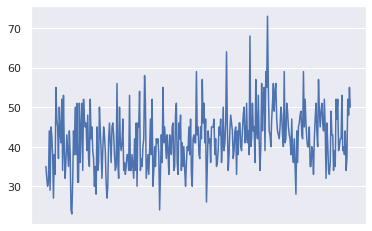

In [ ]:
# load and plot daily births dataset
from pandas import read_csv
from matplotlib import pyplot
# load
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv', header=0, index_col=0)
# summarize shape
print(series)
print(series.shape)
# plot
pyplot.plot(series)
pyplot.xticks([])
pyplot.show()

In [ ]:
# grid search simple forecast for daily female births
from math import sqrt
from numpy import mean
from numpy import median
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
from pandas import read_csv

# one-step simple forecast
def simple_forecast(history, config):
  n, offset, avg_type = config
  # persist value, ignore other config
  if avg_type == 'persist':
    return history[-n]
  # collect values to average
  values = list()
  if offset == 1:
   values = history[-n:]
  else:
    # skip bad configs
    if n*offset > len(history):
      raise Exception('Config beyond end of data: %d %d' % (n,offset))
    # try and collect n values using offset
    for i in range(1, n+1):
      ix = i * offset
      values.append(history[-ix])

  # check if we can average
  if len(values) < 2:
    raise Exception('Cannot calculate average')
  # mean of last n values
  if avg_type == 'mean':
    return mean(values)
  # median of last n values
  return median(values)

# root mean squared error or rmse
def measure_rmse(actual, predicted):
  return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
  return data[:-n_test], data[-n_test:]

 # walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
  predictions = list()
  # split dataset
  train, test = train_test_split(data, n_test)
  # seed history with training dataset
  history = [x for x in train]
  # step over each time-step in the test set
  for i in range(len(test)):
    # fit model and make forecast for history
    yhat = simple_forecast(history, cfg)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])
    # estimate prediction error
  error = measure_rmse(test, predictions)
  return error 

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
  result = None
  # convert config to a key
  key = str(cfg)
  # show all warnings and fail on exception if debugging
  if debug:
    result = walk_forward_validation(data, n_test, cfg)
  else:
   # one failure during model validation suggests an unstable config
    try:
    # never show warnings when grid searching, too noisy
      with catch_warnings():
        filterwarnings("ignore")
        result = walk_forward_validation(data, n_test, cfg)
    except:
      error = None
  # check for an interesting result
  if result is not None:
    print(' > Model[%s] %.3f' % (key, result))
  return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
  scores = None
  if parallel:
    # execute configs in parallel
    executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
    tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
    scores = executor(tasks)
  else:
    scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
  # remove empty results
  scores = [r for r in scores if r[1] != None]
  # sort configs by error, asc
  scores.sort(key=lambda tup: tup[1])
  return scores

# create a set of simple configs to try
def simple_configs(max_length, offsets=[1]):
  configs = list()
  for i in range(1, max_length+1):
    for o in offsets:
      for t in ['persist', 'mean', 'median']:
        cfg = [i, o, t]
        configs.append(cfg)
  return configs

if __name__ == '__main__':
  # define dataset
  series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv', header=0, index_col=0)
  data = series.values
  # data split
  n_test = 165
  # model configs
  max_length = len(data) - n_test
  cfg_list = simple_configs(max_length)
  # grid search
  scores = grid_search(data, cfg_list, n_test)
  print('done')
  # list top 3 configs
  for cfg, error in scores[:3]:
    print(cfg, error)

 > Model[[1, 1, 'persist']] 8.722
 > Model[[2, 1, 'persist']] 9.284
 > Model[[2, 1, 'mean']] 7.884
 > Model[[3, 1, 'persist']] 9.320
 > Model[[2, 1, 'median']] 7.884
 > Model[[3, 1, 'mean']] 7.518
 > Model[[3, 1, 'median']] 7.324
 > Model[[4, 1, 'persist']] 9.249
 > Model[[5, 1, 'persist']] 9.415
 > Model[[5, 1, 'mean']] 7.204
 > Model[[4, 1, 'mean']] 7.290
 > Model[[4, 1, 'median']] 7.217
 > Model[[5, 1, 'median']] 7.337
 > Model[[6, 1, 'persist']] 9.737
 > Model[[6, 1, 'mean']] 7.222
 > Model[[7, 1, 'median']] 7.340
 > Model[[8, 1, 'persist']] 10.172
 > Model[[8, 1, 'mean']] 7.140
 > Model[[8, 1, 'median']] 7.331
 > Model[[9, 1, 'persist']] 10.175
 > Model[[9, 1, 'mean']] 7.200
 > Model[[6, 1, 'median']] 7.230
 > Model[[7, 1, 'persist']] 8.791
 > Model[[9, 1, 'median']] 7.302
 > Model[[10, 1, 'persist']] 9.956
 > Model[[7, 1, 'mean']] 7.042
 > Model[[13, 1, 'persist']] 10.020
 > Model[[10, 1, 'mean']] 7.209
 > Model[[13, 1, 'mean']] 7.238
 > Model[[10, 1, 'median']] 7.349
 > Model[[1